In [1]:
import requests
import json
import pandas as pd
import datetime
import math


In [2]:
def pullNovelData(novelURL):
    a,b,c,d,novel = novelURL.split('/')
    novel_data = json.loads(requests.get("https://www.wuxiaworld.com/api/novels/details/{}".format(novel)).text)
    novel_len = len(novel_data['item']['chapterGroups'])
    novel_df = pd.DataFrame()
    for i in range(novel_len):
        temp_df = pd.DataFrame(novel_data['item']['chapterGroups'][i]['chapters'])
        frames = [novel_df, temp_df]
        novel_df = pd.concat(frames)
    del novel_df['isTeaser']
    novel_df.set_index('number',inplace=True)
    novel_df['whenToPublish'] = pd.to_datetime(novel_df['whenToPublish'],unit='s')
    #Save as CSV
    #novel_df.to_csv('{} chapters.csv'.format(novel))
    
    return novel_df

In [3]:
def pullComments(id):
    json_comments = json.loads(requests.get("https://www.wuxiaworld.com/api/comments/{}/top".format(id)).text)
    pages = math.ceil(json_comments['totalTopLevel']/25)
    comments = []
    for i in range(pages):
        page = i + 1
        append = json.loads(requests.get("https://www.wuxiaworld.com/api/comments/{}/top?page={}".format(id,page)).text)
        comments = comments + append['items']
    comments = pd.DataFrame(comments)
    #comments['timeCommented'] = pd.to_datetime(comments['timeCommented'],unit='s')
    #comments['joinDate'] = pd.to_datetime(comments['joinDate'],unit='s')
    #del comments['avatar']
    #del comments['approved']
    #del comments['deleted']
    #del comments['children'] # ignore children
    return comments ##list of comments
    #return comments ## returns Data Frame of comments

In [5]:
def pullAllComments(novelDF):
    rows, columns = novelDF.shape
    novel_ids = novelDF['id'].tolist()
    novel_numbers = novelDF.index.tolist()
    columns = ['approved', 'avatar', 'children', 'content', 'deleted', 'depth',
       'downVotes', 'edited', 'flair', 'id', 'joinDate', 'poster', 'posterId',
       'timeCommented', 'upVotes', 'vip','chID','chNumber']
    novel_comments = pd.DataFrame(columns=columns)
    for i in range(rows):
        ch_id = novel_ids[i]
        ch_number = novel_numbers[i]
        ch_comments = pullComments(ch_id)
        ch_comments['chID'] = ch_id
        ch_comments['chNumber'] = ch_number
        novel_comments = pd.concat([novel_comments,ch_comments])
    novel_comments.reset_index(inplace=True)
    return novel_comments
        

In [65]:
def cleanComments(comments):
    
    # Converting from unix time stamp to regular date time and date.
    comments['timeCommented'] = pd.to_datetime(comments['timeCommented'],unit='s')
    comments['dateCommented'] = comments['timeCommented'].apply(lambda x: datetime.datetime.date(x))
    comments['joinDate'] = pd.to_datetime(comments['joinDate'],unit='s')
    
    del comments['index'] # redundant index column which was associated with comment number for a specific chapter.
    del comments['avatar']  # User avatar image is not related to goal of sentimentality analysis and image analysis is outside the scope of the project's goal.
    del comments['approved'] # All rows are true. Useless feature.
    del comments['deleted']  # All rows are false. Useless feature.
    del comments['children'] # Child comments are swayed by other comments, so they add unessary complexity to the analysis.
    del comments['depth']    # Depth is irrelevant since all commments are top level now.
    del comments['edited']   # Whether a comment has been edited or not is irrelevant due to how the comment editing system works.
    del comments['flair']    # too few users have flairs for this feature to be signifigant as of now. It's an interesting feature to look at once user flair functionality is expanded.

    
    # By ignoring child comments, each comment is more more like a review. 

In [49]:
novelData = pullNovelData('https://www.wuxiaworld.com/novel/a-will-eternal')

In [50]:
novelData.drop([-2.0,-1.0],inplace=True)

In [70]:
sample_data = pullAllComments(novelData.head(10))

In [52]:
sample_data.to_excel("sample_data_exl.xlsx", "comment data")

In [78]:
cleanComments(sample_data)

In [79]:
sample_data.head()

,content,downVotes,id,joinDate,poster,posterId,timeCommented,upVotes,vip,chID,chNumber,dateCommented
0,Eh I planned to have the first this time! \r\n...,0,388011,2016-06-20 14:11:41,Tsuna,6496bc35-b714-4708-945f-a65bab6c98ff,2016-12-10 14:05:01,3,False,11983,1.0,2016-12-10
1,A Splendid Translation of A Will Eternal Chapt...,0,388066,2015-09-01 19:22:04,zaltrhiz,30d5304d-1fb7-46c4-b310-e285d11846b9,2016-12-10 15:12:23,3,False,11983,1.0,2016-12-10
2,"i'm currently studying chinese at university, ...",0,388060,2015-12-22 16:19:58,miticogiorgio,339c502b-3863-4058-a055-a95ab768383c,2016-12-10 15:05:42,2,False,11983,1.0,2016-12-10
3,"Yesterday I finished to reading ISSTH, wuuw~ I...",0,388125,2017-07-02 23:43:27,Feyre,86ee31f7-55a6-4d99-be91-fc75d3c7f65b,2017-09-05 21:53:51,2,False,11983,1.0,2017-09-05
4,Thanks for the chapter!\nRead about 100 chapte...,0,388005,2015-07-28 19:43:57,Danik02,022d606d-6cd8-465e-b724-54bd7b7e95d9,2016-12-10 13:58:31,1,False,11983,1.0,2016-12-10


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [18]:
def sentimentScore(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt['compound']

In [19]:
def calcSentScores(data):
    data['sentiment'] = data['content'].apply(sentimentScore)

In [26]:
def sentimentStats(data):
    print(data['sentiment'].describe())

In [71]:
def chSentScores(data):
    return data.groupby(['chNumber']).mean()

In [73]:
def dateSentScores(data):
    return data.groupby(['dateCommented']).mean()

In [136]:
def userSentScores(data):
    return data.groupby(['posterId'])[['posterId','sentiment']].mean()

In [89]:
calcSentScores(sample_data)

In [90]:
sample_data.head()

,content,downVotes,id,joinDate,poster,posterId,timeCommented,upVotes,vip,chID,chNumber,dateCommented,sentiment
0,Eh I planned to have the first this time! \r\n...,0,388011,2016-06-20 14:11:41,Tsuna,6496bc35-b714-4708-945f-a65bab6c98ff,2016-12-10 14:05:01,3,False,11983,1.0,2016-12-10,0.6114
1,A Splendid Translation of A Will Eternal Chapt...,0,388066,2015-09-01 19:22:04,zaltrhiz,30d5304d-1fb7-46c4-b310-e285d11846b9,2016-12-10 15:12:23,3,False,11983,1.0,2016-12-10,0.8225
2,"i'm currently studying chinese at university, ...",0,388060,2015-12-22 16:19:58,miticogiorgio,339c502b-3863-4058-a055-a95ab768383c,2016-12-10 15:05:42,2,False,11983,1.0,2016-12-10,0.0000
3,"Yesterday I finished to reading ISSTH, wuuw~ I...",0,388125,2017-07-02 23:43:27,Feyre,86ee31f7-55a6-4d99-be91-fc75d3c7f65b,2017-09-05 21:53:51,2,False,11983,1.0,2017-09-05,0.4003
4,Thanks for the chapter!\nRead about 100 chapte...,0,388005,2015-07-28 19:43:57,Danik02,022d606d-6cd8-465e-b724-54bd7b7e95d9,2016-12-10 13:58:31,1,False,11983,1.0,2016-12-10,0.9707


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [91]:
chSent = chSentScores(sample_data)

In [92]:
chSent.reset_index(inplace=True)

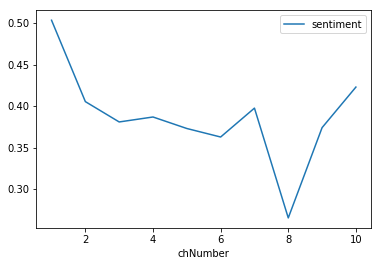

In [93]:
chSent.plot(x='chNumber', y='sentiment', kind='line')

In [94]:
dateSent = dateSentScores(sample_data)

In [97]:
dateSent.reset_index(inplace=True)

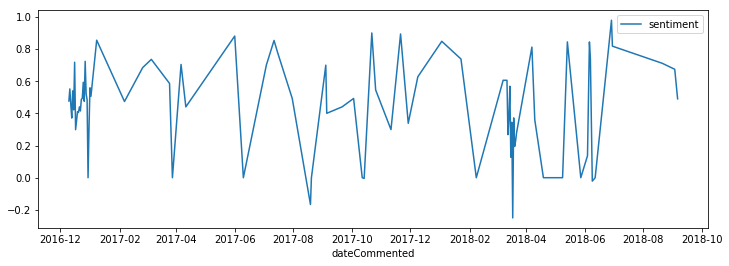

In [144]:
dateSent.plot(x='dateCommented', y='sentiment', kind='line', figsize=(12,4))

In [137]:
userSent = userSentScores(sample_data)

In [138]:
userSent.head()

,sentiment
posterId,
001d83b3-aaf7-4c0f-8631-cd5539a93736,0.85480
0071251a-82db-4694-bee2-8654863cebc5,0.88050
014f4a60-82b3-4b12-9ad2-eedb54d2cf66,0.49260
0186f391-6a3b-4f0d-9fe9-95d68f4e9b14,0.51807
022d606d-6cd8-465e-b724-54bd7b7e95d9,0.97070


In [139]:
userSent.reset_index(inplace=True)


In [140]:
userSent.index

RangeIndex(start=0, stop=226, step=1)

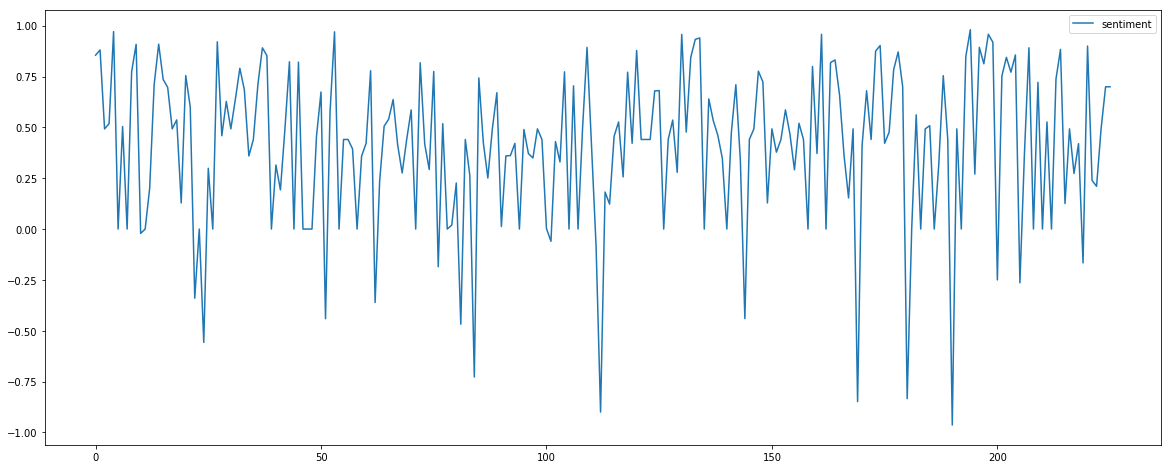

In [143]:
userSent.plot(x=userSent.index, y='sentiment', kind='line', figsize=(20,8))